In [2]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu

fsaverage = datasets.fetch_surf_fsaverage()

C:\Users\gunnerstone\.conda\envs\algo\lib\site-packages\nilearn\datasets\__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [5]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
        #print(p)
        #ret_di = pickle.load(f)
    return ret_di

  

def visualize_activity(vid_id,sub):
  # Setting up the paths for whole brain data
  fmri_dir = './participants_data_v2021' 
  track = "full_track"

  # get the right track directory depending on whole brain/ROI choice
  track_dir = os.path.join(fmri_dir, track)  

  # get the selected subject's directory 
  sub_fmri_dir = os.path.join(track_dir, sub)
  
  #result directory to store nifti file
  results_dir = '/content/'

  # mapping the data to voxels and storing in a nifti file
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB") 
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:] 
  brain_mask = './example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)

  # visualizing saved nifti file
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

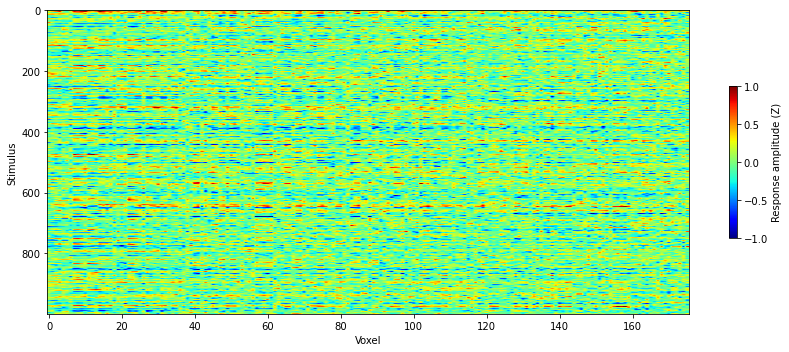

In [6]:
def nothing():
    #@title Loading fMRI data and inspecting dimensions
    # Select Subject
    sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

    # Select ROI
    ROI = 'V1'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

    ######## fMRI data loader wrapper code ###################################
    fmri_dir = './participants_data_v2021' 
    if ROI == "WB":  # Loading whole brain data 
        track = "full_track"  # stored in full_track directory
    else:  # Loading ROI data
        track = "mini_track" # stored in mini_track directory

    # get the right track directory depending on whole brain/ROI choice
    track_dir = os.path.join(fmri_dir, track)  

    # get the selected subject's directory 
    sub_fmri_dir = os.path.join(track_dir, sub)

    # Load the fMRI data for the selected subject and ROI
    if track == "full_track":
        fmri_train_all,_ = get_fmri(sub_fmri_dir,ROI)
    else:
        fmri_train_all = get_fmri(sub_fmri_dir,ROI)

    ######## fMRI data loader wrapper code ###################################

    # Visualize the fMRI responses in a heatmap
    f, ax = plt.subplots(figsize=(12, 5))
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
    f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    f.tight_layout()

(1000, 176)
<class 'numpy.ndarray'>


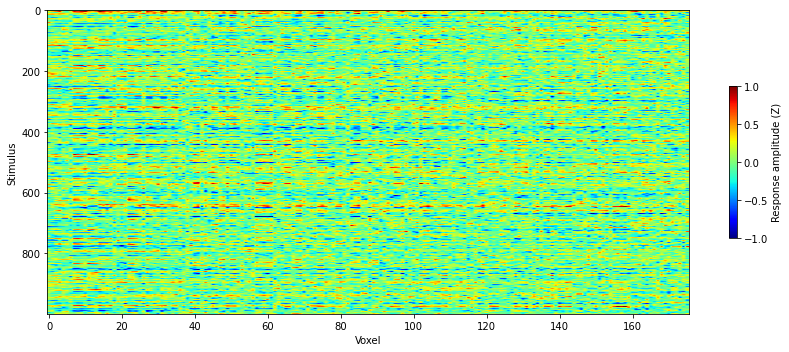

In [14]:
def nothing2():
    #@title Loading fMRI data and inspecting dimensions
    # Select Subject
    sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

    # Select ROI
    ROI = 'V1'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

    ######## fMRI data loader wrapper code ###################################
    fmri_dir = './participants_data_v2021' 
    if ROI == "WB":  # Loading whole brain data 
        track = "full_track"  # stored in full_track directory
    else:  # Loading ROI data
        track = "mini_track" # stored in mini_track directory

    # get the right track directory depending on whole brain/ROI choice
    track_dir = os.path.join(fmri_dir, track)  

    # get the selected subject's directory 
    sub_fmri_dir = os.path.join(track_dir, sub)

    # Load the fMRI data for the selected subject and ROI
    if track == "full_track":
        fmri_train_all,_ = get_fmri(sub_fmri_dir,ROI)
    else:
        fmri_train_all = get_fmri(sub_fmri_dir,ROI)

    ######## fMRI data loader wrapper code ###################################
    print (fmri_train_all.shape)
    #print the variable type of fmri_train_all
    print (type(fmri_train_all))

    # Visualize the fMRI responses in a heatmap
    f, ax = plt.subplots(figsize=(12, 5))
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
    f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    f.tight_layout()

In [17]:
def get_label(video, subject='sub01', roi='V1'):
    """This function loads the labels for a given video and subject.
    Parameters
    ----------
    video : str
        name of video.
    subject : str
        name of subject.
    roi : str
    """
    # Select Subject
    sub = subject  #["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

    # Select ROI
    ROI = roi  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

    ######## fMRI data loader wrapper code ###################################
    fmri_dir = './participants_data_v2021' 
    if ROI == "WB":  # Loading whole brain data 
        track = "full_track"  # stored in full_track directory
    else:  # Loading ROI data
        track = "mini_track" # stored in mini_track directory

    # get the right track directory depending on whole brain/ROI choice
    track_dir = os.path.join(fmri_dir, track)  

    # get the selected subject's directory 
    sub_fmri_dir = os.path.join(track_dir, sub)

    # Load the fMRI data for the selected subject and ROI
    if track == "full_track":
        fmri_train_all,_ = get_fmri(sub_fmri_dir,ROI)
    else:
        fmri_train_all = get_fmri(sub_fmri_dir,ROI)

    ######## fMRI data loader wrapper code ###################################
    # print (fmri_train_all.shape)
    
    #get the video id contained in the first 4 characters of the video name, make sure it is an int
    video_id = int(video[0:4])

    #get the row of fmri_train_all corresponding to the video id
    video_row = fmri_train_all[video_id,:]
    return video_row
    
    #print the shape of video_row
    # print (video_row.shape)
    

    #print the variable type of fmri_train_all
    # print (type(fmri_train_all))
# get_label('0001', 'sub01', 'V1')

(1000, 232)
(232,)
<class 'numpy.ndarray'>


In [11]:
def nothing3():
    #@title Visualize video
    vid_id = 2 #@param {type: "integer"}
    video_dir = './AlgonautsVideos268_All_30fpsmax'

    ########### Video display code #################################################
    video_list = glob.glob(video_dir + '/*.mp4')
    video_list.sort()

    from IPython.display import HTML
    from base64 import b64encode

    mp4 = open(video_list[vid_id],'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)
    ########### Video display code #################################################